In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
with open('/kaggle/input/indian-names-boys-girls/Names.txt', 'r', encoding='utf-8') as f:
    words = f.readlines()

# Strip whitespace/newlines
words = [name.strip() for name in words]

# Show first few names
print(len(words))


55691


In [12]:
names = [n.lower() for n in words]

cleaned_names = []
for n in names:
    vn = ''
    for ch in n:
        if ch in [' ', '-', '.']:
            break
        vn += ch
    cleaned_names.append(vn)

words = cleaned_names
print(len(words))


55691


In [13]:
vocab_size = 27
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [14]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [15]:
X.shape, X.dtype, Y.shape, Y.dtype
print(X , "--->" ,Y)

tensor([[ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1,  1],
        ...,
        [21, 22,  1],
        [22,  1, 11],
        [ 1, 11,  1]]) ---> tensor([ 1,  1,  2,  ..., 11,  1,  0])


In [16]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([400268, 3]) torch.Size([400268])
torch.Size([49979, 3]) torch.Size([49979])
torch.Size([50069, 3]) torch.Size([50069])


In [9]:
# g = torch.Generator().manual_seed(2147483647) # for reproducibility
# C = torch.randn((27, 10), generator=g)
# W1 = torch.randn((30, 200), generator=g)
# b1 = torch.randn(200, generator=g)
# W2 = torch.randn((200, 27), generator=g)
# b2 = torch.randn(27, generator=g)
# parameters = [C, W1, b1, W2, b2]

In [29]:
# -----------------TRAIN----------------------------

In [46]:
# # MLP 
n_embd = 10 # the dimension of the embedding vector of a character 
n_hidden = 200 # number of nuerons in the hidden layer 

# # ISSUE -- 1
# # ideally the loss in the first iteration should not be too high because all the letter are equally likely
# # to appear and we there are 27 character so the probability should be log(1/27) but we see a very high loss
# # intitially just because of random intialisation of weights in the hidden layer so we will reduce try to get 
# # rougly equal weigths not zero because of symmetry breaking otherwise they will learn the same thing 
# # and will make the bias zero 


# # ISSUE -- 2  fixing saturated tanh
# """as plotted below we can see that the the activation of neuron gets saturated to 1 and -1 that is at the ends of 
# the graph and derivatide of tanh there becomes 0 and so there is no net learning of that nueron during backpropagation
# hence we have to consider that issue as lots of neuron will become dead after that so the major issue is that input to
# our activation is extreme cause our actiavtion to go near the ends so we will reduce the weights and bias
# """

# # The best initialisatiopn for the actiavtion weights would be the keining_initialisation (pytorch documentation go and read)


# # these perfect intialisation are not used much days due to advancement in some more more techniques one is batch_normalisation

g = torch.Generator().manual_seed(21474836747)
C = torch.randn((vocab_size, n_embd),                generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden),    generator = g) * (5/3)/((n_embd*block_size)**0.5) # will do keining initialisation now* 0.1
b1 = torch.randn(n_hidden,                           generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),             generator = g) * 0.01
b2 = torch.randn(vocab_size,                         generator = g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True  # this will now run properly

In [47]:
for p in parameters:
  p.requires_grad = True

In [48]:
sum(p.nelement() for p in parameters)

12297

In [49]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [50]:
lri = []
lossi = []
stepi = []

In [51]:
num_steps = 200000
for i in range(num_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  # h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  embcat = (emb.view(-1, 30))  
  hpreact = embcat @ W1 + b1
  hpreact = bngain*((hpreact - bnmean_running) / bnstd_running) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2   
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
      
  loss.backward()
  
  # update
  # lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
      p.data += -lr * p.grad


  if(i % 10000 == 0):
      print(f" {i}/{num_steps}: {loss.item()}")
  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())



 0/200000: 3.2828245162963867
 10000/200000: 2.228116035461426
 20000/200000: 1.8813525438308716
 30000/200000: 2.3152875900268555
 40000/200000: 1.4496486186981201
 50000/200000: 1.5801644325256348
 60000/200000: 1.770136833190918
 70000/200000: 1.894934058189392
 80000/200000: 2.03818678855896
 90000/200000: 1.8758642673492432
 100000/200000: 2.0687642097473145
 110000/200000: 1.7891072034835815
 120000/200000: 1.9076457023620605
 130000/200000: 2.32507586479187
 140000/200000: 1.6764858961105347
 150000/200000: 1.502487301826477
 160000/200000: 1.8241103887557983
 170000/200000: 2.095806360244751
 180000/200000: 1.784759283065796
 190000/200000: 1.781199336051941


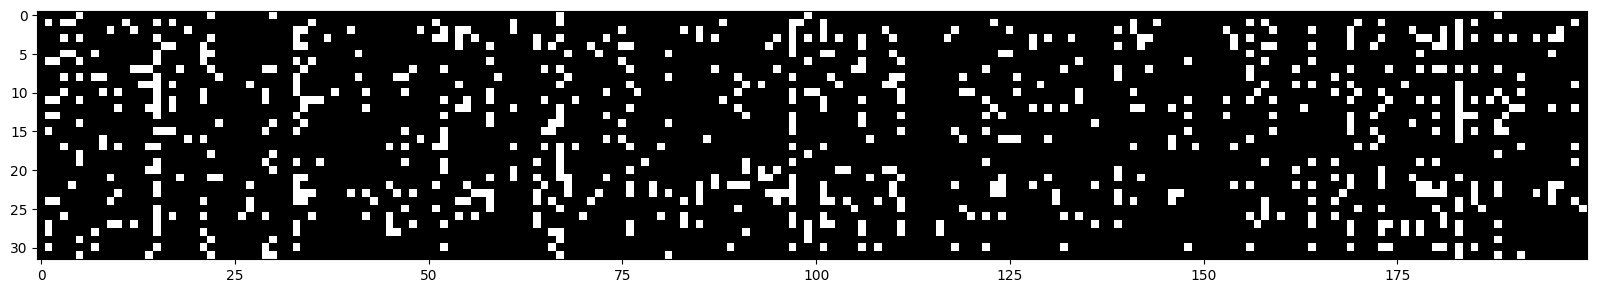

In [52]:
plt.figure(figsize= (20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')

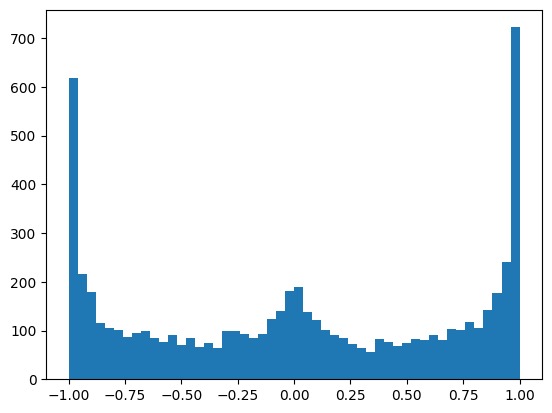

In [53]:
# here we can see that a lots of activation are in outer range that is -1 and 1 and this causes our neuron to not learn anything 
# because the gradient there is 0 and during backpropagation we could not change the weights or optimise tha because of 0 gradients 
plt.hist(h.view(-1).tolist(), 50);

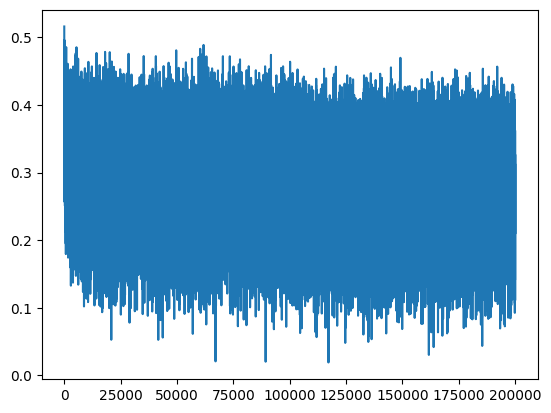

In [54]:
plt.plot(stepi, lossi)

In [55]:
#  calibrate the batch norm at the end of training

with torch.no_grad():

    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim= True)
    bnstd = hpreact.std(0, keepdim = True)

In [57]:
@torch.no_grad() #disables gradient tracking
def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr),
        'test' : (Xte, Yte),
        'val' : (Xdev, Ydev),
    }[split]

    emb = C[x]                          # (37, 3, 2)
    embcat = (emb.view(emb.shape[0], -1))  # (37, 100)
    hpreact = embcat @ W1 + b1
    # batch normalization step
    hpreact = bngain*((hpreact - bnmean_running) / bnstd_running) + bnbias
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2                # (37, 27)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')
    

train 1.8956680297851562
val 1.9145927429199219
test 1.9110193252563477


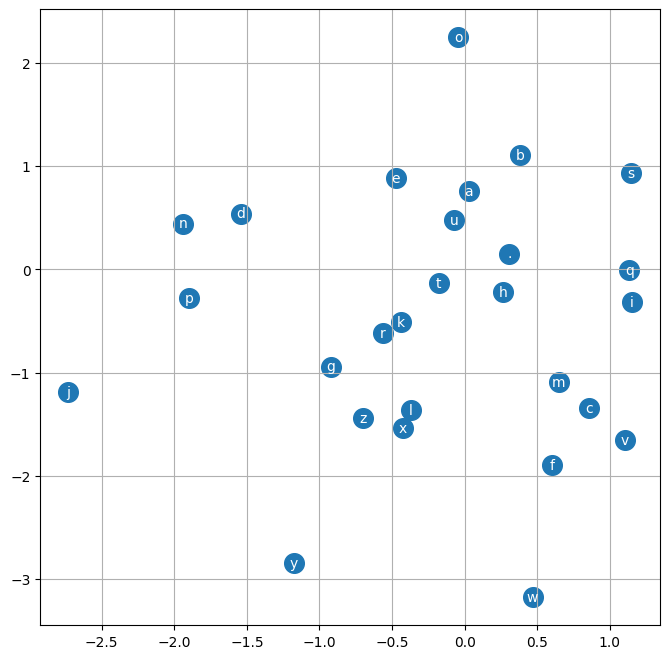

In [58]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha= "center", va = "center", color= "white")
plt.grid('minor')

In [59]:
# sampling from the model
g = torch.Generator().manual_seed(21474836747 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = (emb.view(1, -1))  
        hpreact = embcat @ W1 + b1
        # batch normalization step
        hpreact = bngain*((hpreact - bnmean_running) / bnstd_running) + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2   
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples=1 , generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

prakshiyan.
rinesh.
jayankanthiyadhya.
sathi.
aakhithirubanga.
ala.
aadaksha.
nerois.
prasathiveshakavinoshighanusarshinshuvarmani.
vethanushha.
akodurshri.
varshi.
aniyavithesha.
nithawimika.
shaamalan.
sishya.
shvidevath.
vimal.
rushakhi.
thi.


In [61]:
# here i took a step forward cnd implement the a network with which takes 3 blocks in a sequence and output
# next character in that sequence using softmax loss we have embedding of each alphabet of size 10 and we concatenate
# the three embedding vector and feed into the first layer and used tanh activation for non - linearity then 
# that is passed to another layer to output the logits of the softmax and then find the probability of the next sequenced
# i formed splits here training testing and validation and each losses are: 
# train 1.8956680297851562
# val 1.9145927429199219
# test 1.9110193252563477 respectively 

# also implemented batch normalization here lets go to the next implementation
